In [1]:
import torch
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm

In [2]:
torch.cuda.is_available()

True

In [3]:
df = pd.read_csv('C:\\Users\\21341038\\Downloads\\SarcasDetection.csv' )


In [4]:
df.head(10)

,Unnamed: 0,Comments,Label
0,0,আমি মনে করি যখন মেয়েরা উদ্দেশ্য অনুসারে বোবা ...,1.0
1,1,আমি যখন কোনও গুরুত্বপূর্ণ প্রশ্ন জিজ্ঞাসা করি ...,1.0
2,2,বাহ ... আমি দেখতে দেখতে পাচ্ছি সত্যিই দোষী দোষ...,1.0
3,3,"হাহ, মজার বিষয়।#আনোয়েড #গ্রুআপ",1.0
4,4,থান্ডার আমাকে 830 এ জেগে উঠলে এটি ভালবাসুন,1.0
5,5,"আজ আমাকে খোদাই করার জন্য ধন্যবাদ, যথাযথ ভাল বন...",1.0
6,6,আমি এমন পরিকল্পনাগুলি পছন্দ করি যা কখনই ঘটে না...,1.0
7,7,"আমি যখন কাউকে দীর্ঘশ্বাস শুনি, ‘জীবন কঠিন,’ আম...",1.0
8,8,"আমি বলছি না আমি আপনাকে ঘৃণা করি, আমি যা বলছি ত...",1.0
9,9,"আমি এখনই ব্যস্ত, আমি কি আপনাকে অন্য কোনও সময় ...",1.0


<Axes: xlabel='Label', ylabel='count'>

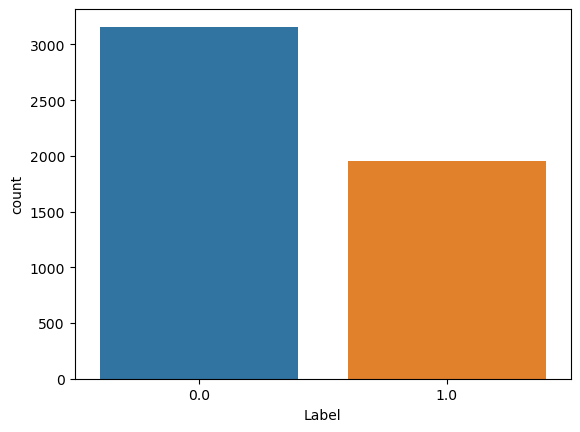

In [5]:
import seaborn as sns
sns.countplot(x='Label', data=df)

In [6]:
tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base')

encoded_data = tokenizer.batch_encode_plus(
    df['Comments'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    truncation=True,
    max_length=128,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = df['Label'].tolist()

In [7]:

train_inputs, valtest_inputs, train_labels, valtest_labels = train_test_split(
    input_ids, labels, random_state=42, test_size=0.2
)

val_inputs, test_inputs, val_labels, test_labels = train_test_split(
    valtest_inputs, valtest_labels, random_state=42, test_size=0.5
)

train_masks, valtest_masks, _, _ = train_test_split(
    attention_masks, labels, random_state=42, test_size=0.2
)

val_masks, test_masks, _, _ = train_test_split(
    valtest_masks, valtest_labels, random_state=42, test_size=0.5
)


In [8]:
class Dataset(Dataset):
    def __init__(self, inputs, masks, labels):
        self.inputs = inputs
        self.masks = masks
        self.labels = labels

    def __getitem__(self, index):
        return {
            'input_ids': self.inputs[index],
            'attention_mask': self.masks[index],
            'labels': torch.LongTensor([self.labels[index]])  
        }

    def __len__(self):
        return len(self.inputs)

train_dataset = Dataset(train_inputs, train_masks, train_labels)
val_dataset = Dataset(val_inputs, val_masks, val_labels)
test_dataset = Dataset(test_inputs, test_masks, test_labels)


In [9]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader

# Load pre-trained model
model = BertForSequenceClassification.from_pretrained('sagorsarker/bangla-bert-base', num_labels=2)


optimizer = AdamW(model.parameters(), lr= 2e-5 )
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [10]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}', leave=False)
    for batch in progress_bar:
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device),
            'labels': batch['labels'].to(device)
        }

        optimizer.zero_grad()

        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'Training Loss': loss.item()})

    avg_train_loss = total_loss / len(train_dataloader)

    model.eval()
    val_loss = 0
    val_predictions = []
    val_true_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device),
                'labels': batch['labels'].to(device)
            }

            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            _, predicted_labels = torch.max(logits, dim=1)
            val_predictions.extend(predicted_labels.cpu().numpy())
            val_true_labels.extend(inputs['labels'].cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)

    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    print(f'Epoch {epoch+1}:')
    print(f'Training Loss: {avg_train_loss:.4f}')
    print(f'Validation Loss: {avg_val_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')


Epoch 1:
Training Loss: 0.2528
Validation Loss: 0.1023
Validation Accuracy: 0.9667


Epoch 2:
Training Loss: 0.0857
Validation Loss: 0.0899
Validation Accuracy: 0.9667


Epoch 3:
Training Loss: 0.0385
Validation Loss: 0.0731
Validation Accuracy: 0.9746


In [11]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

def test_model(model, test_dataloader):
    model.eval()
    test_predictions = []
    test_true_labels = []

    with torch.no_grad():
        for batch in test_dataloader:
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device),
                'labels': batch['labels'].to(device)
            }

            outputs = model(**inputs)
            logits = outputs.logits

            _, predicted_labels = torch.max(logits, dim=1)
            test_predictions.extend(predicted_labels.cpu().numpy())
            test_true_labels.extend(inputs['labels'].cpu().numpy())

    test_accuracy = accuracy_score(test_true_labels, test_predictions)
    test_precision = precision_score(test_true_labels, test_predictions, average='macro')
    test_recall = recall_score(test_true_labels, test_predictions, average='macro')
    test_f1 = f1_score(test_true_labels, test_predictions, average='macro')
    cm = confusion_matrix(test_true_labels, test_predictions)

    # Normalize the Confusion Matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print('Testing Results:')
    print(f'Testing Accuracy: {test_accuracy:.4f}')
    print(f'Testing Precision (Macro): {test_precision:.4f}')
    print(f'Testing Recall (Macro): {test_recall:.4f}')
    print(f'Testing F1-Score (Macro): {test_f1:.4f}')

    # Visualize the Confusion Matrix
    labels = ['not Sarcasm', 'Sarcasm']
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Normalized Confusion Matrix')
    plt.show()
    print(cm)


Testing Results:
Testing Accuracy: 0.9590
Testing Precision (Macro): 0.9561
Testing Recall (Macro): 0.9584
Testing F1-Score (Macro): 0.9572


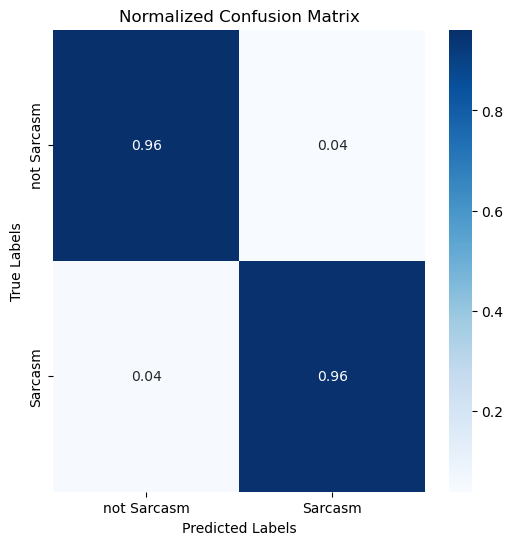

[[298  12]
 [  9 193]]


In [12]:
test_model(model, test_dataloader)